# Notebook for detecting multi-resolution clonal structures with Wave-LSTM

This notebook reproduces the plots found in the accompanying paper, and loads parameters from a cached output file. Experiments can be re-produced using the scripts found in the above directory. This will also generate additional run-time plots using WandB logging callbacks.

In [1]:
import numpy as np
import pickle as pkl
import torch
import pandas as pd
from IPython.display import display, HTML
import umap
import sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralBiclustering
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import style
from matplotlib import colors
import palettable
from palettable.colorbrewer.qualitative import Set1_6 as pallette
import omegaconf
import os
import wandb
import pytorch_lightning as pl

from TCGA.data_modules.CHISEL_S0E.loaders import DataModule, Dataset
from sklearn import preprocessing
from WaveLSTM.custom_callbacks.waveLSTM import SaveOutput
from waveLSTM.src.WaveLSTM.models.base import WaveletBase
from WaveLSTM.models.attentive_autoencoder import create_sa_autoencoder, AttentiveAutoEncoder

# Plotting set up
sns.set()
sns.set_palette(pallette.mpl_colors)
cmap = plt.cm.Blues
norm = colors.BoundaryNorm(np.arange(-0.5, 8.5, 1), cmap.N)

# turn off wandb to avoid updating project
wandb.init(mode="disabled")

Seed set to 42


In [2]:
# Set working directory to root of experiment
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [3]:
def stack_batches(dataloader):
    # Stack all test data for test hook
    CNA, labels = [], []
    for batch in iter(dataloader()):
        CNA.append(batch["CNA"])
        labels.append(batch["label"])
    return {"CNA": torch.concat(CNA, 0),
            "label": torch.concat(labels, 0),
            }

# Load default configuration

In [4]:
cfg = omegaconf.OmegaConf.load("confs/autoencoder_config.yaml")

# Choose which seed checkpoint to load
if False:
    cfg["data"]["stack"] = False
    cfg.encoder.waveLSTM.J = 5
    checkpoint = "waveLSTM_h256_p64_stackFalse"
else:
    checkpoint = "waveLSTM_h256_p64_stackTrue"

for _key in cfg.keys():
    print(cfg[_key])

{'batch_size': 32, 'chr_length': 256, 'stack': True}
{'project_name': 'WaveLSTM-ClonalAE', 'num_epochs': 75, 'run_id': '${encoder.base.method}_${experiment.seed}_stack$data.stack', 'save_file': 'outputs/${experiment.run_id}.pkl', 'train': True, 'verbose': True, 'pool_targets': True, 'seed': 42}
{'r_hops': 1, 'attention_unit': 350}
{'base': {'D': 3, 'method': 'waveLSTM'}, 'waveLSTM': {'wavelet': 'haar', 'J': 8, 'layers': 1, 'hidden_channels': 256, 'proj_size': 64}}
{'base': {'method': 'rccae'}, 'rccae': None, 'fc': None}


# Get data

In [5]:
# Load data
dm = DataModule(**cfg.data)

# View a batch from the dataloader
for batch in dm.train_dataloader():
    for _key in batch.keys():
        print(f"{_key}:".ljust(10) + f"{batch[_key].shape}")
    break

CNA:      torch.Size([32, 2, 5632])
label:    torch.Size([32])


In [6]:
le = dm.train_set.label_encoder
labels = le.classes_
classes = len(le.classes_)
channels = batch["CNA"].shape[1]
W = batch["CNA"].shape[-1]

lbl, lbl_idx = np.unique(dm.train_set.data_frame.CLONE, return_index=True)

# Plotting data (noise free)
training_frame = dm.train_set.data_frame
# validation_frame = dm.validation_set.data_frame
# test_frame = dm.test_set.data_frame

display(training_frame.head())

,X.CHR,START,END,NORM_COUNT,COUNT,RDR,A_COUNT,B_COUNT,BAF,CLUSTER,CN_STATE,CLONE
CELL,,,,,,,,,,,,
AAACCTGCACCAAAGG,chr1,0,5000000,2654972,547,0.801010,14,23,0.621622,3,1|2,Clone199
AAACCTGCAGGACCAA,chr1,0,5000000,2654972,1340,0.822523,54,26,0.325000,3,2|1,Clone199
AAACCTGGTAACTTCG,chr1,0,5000000,2654972,947,0.874127,43,17,0.283333,3,2|1,Clone199
AAACCTGGTACCTAGT,chr1,0,5000000,2654972,656,1.200903,21,15,0.416667,3,1|1,Clone5
AAACCTGTCGATAAGA,chr1,0,5000000,2654972,831,0.940548,57,16,0.219178,3,2|1,Clone199


## View data

,X.CHR,START,END,NORM_COUNT,COUNT,RDR,A_COUNT,B_COUNT,BAF,CLUSTER,CN_STATE,CLONE
CELL,,,,,,,,,,,,
AAACCTGCACCAAAGG,chr1,0,5000000,2654972,547,0.801010,14,23,0.621622,3,1|2,Clone199
AAACCTGCAGGACCAA,chr1,0,5000000,2654972,1340,0.822523,54,26,0.325000,3,2|1,Clone199
AAACCTGGTAACTTCG,chr1,0,5000000,2654972,947,0.874127,43,17,0.283333,3,2|1,Clone199
AAACCTGGTACCTAGT,chr1,0,5000000,2654972,656,1.200903,21,15,0.416667,3,1|1,Clone5
AAACCTGTCGATAAGA,chr1,0,5000000,2654972,831,0.940548,57,16,0.219178,3,2|1,Clone199


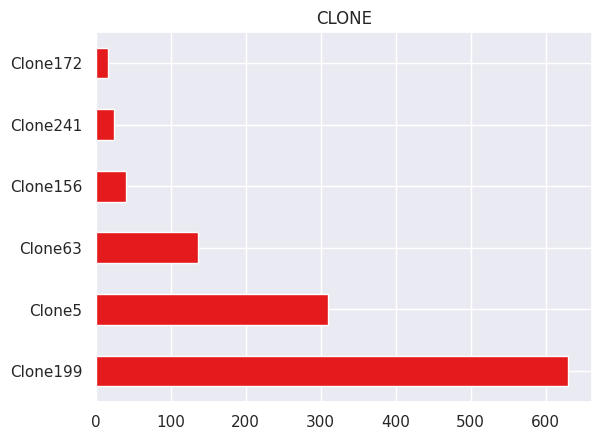

In [7]:
df = training_frame 

df = df.groupby(df.index).first()
display(df.head())

for col_key in ["CLONE"]:
    df[col_key].value_counts().plot(kind = 'barh')
    plt.title(col_key)
    plt.show()



In [8]:
cluster_names = ["I", "II", "III", "IV", "V", "VI"]
print(cluster_names)

['I', 'II', 'III', 'IV', 'V', 'VI']


Collect training, validation, and test features and labels

In [9]:
data, counts = [], []
for set_name, loader in zip(["Train", "Validation", "Test"], [dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader()]):
    print("\n" + set_name + " set \n" + "="*(len(set_name) + 4))
    
    # Combine batches
    features, labels = [], []
    for batch in iter(loader):
        features.append(batch["CNA"])
        labels.append(batch["label"])
    data.append({"CNA": torch.concat(features, 0).numpy().reshape((-1, 2, 22, 256)),
                 "label": torch.concat(labels, 0).numpy()}
               )
    
    # Report count of each clone 
    print(f"{data[-1]['CNA'].shape[0]} samples composed of")
    count = []
    for lbl, cnt in zip(*np.unique(data[-1]['label'], return_counts=True)):
        print(f"{cluster_names[lbl]} with count {cnt}")
        count.append(cnt)
    counts.append(count)


Train set 
1158 samples composed of
I with count 310
II with count 136
III with count 41
IV with count 17
V with count 630
VI with count 24

Validation set 
145 samples composed of
I with count 42
II with count 17
III with count 9
IV with count 1
V with count 73
VI with count 3

Test set 
145 samples composed of
I with count 38
II with count 15
III with count 8
IV with count 2
V with count 79
VI with count 3


# Section 1: Visualisation of CNA data

Select which data set we want to visualise in this section of the notebook, and which chromosome and strand to highlight.

     

In [10]:
subset = 0           # 0=train set, 1=validation set, 2=test set
chromosome = 17      # 1,...,22
strand = 2           # 1=major or 2=minor

Define plotting functions

In [11]:
def plot_chromosomes(features, 
                     xlabel="Chromosomes",
                     ylabel="Clone samples",
                     splits=None, 
                     figsize=(15,5)):

    fshape = features.shape
    features = features.reshape((fshape[0], -1))
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.heatmap(features, 
                ax=ax, cmap=cmap, norm=norm, yticklabels=False,
               ) 
        
    # Vertical lines: indicating which chromosome we are zooming into in third plot
    for _chrom in range(1, 23):
        plt.axvline(x=(_chrom-1)*fshape[-1], color='k', alpha=0.25)
    # Horizontal lines: separating clones
    if splits is not None:
        for split in splits:
            plt.axhline(y=split, color='k', linestyle='-')
        ax.set_yticks((splits[1:] + splits[:-1])/2)
        ax.set_yticklabels(["I", "II", "III", "IV", "V", "VI"])
        
    plt.ylabel(ylabel)
    # X-axis
    ax.set_xticks([ (_chrom+0.5) * fshape[-1] for _chrom in range(22)])
    ax.set_xticklabels([_chrom for _chrom in range(1,23)], rotation=0)
    plt.xlabel(xlabel)
    # Manually specify colorbar labelling after it's been generated
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks(np.arange(0, 8))
    colorbar.minorticks_off() 
    colorbar.set_ticklabels([i for i in range(8)])
    
def plot_chromosome(features, 
                    xlabel="Loci",
                    ylabel="Clone samples",
                    splits=None, 
                    figsize=(8,5)):

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.heatmap(features, 
                ax=ax, cmap=cmap, norm=norm, yticklabels=False,
               ) 
        
    # Horizontal lines: separating clones
    if splits is not None:
        for split in splits:
            plt.axhline(y=split, color='k', linestyle='-')
        ax.set_yticks((splits[1:] + splits[:-1])/2)
        ax.set_yticklabels(["I", "II", "III", "IV", "V", "VI"])
        
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # Manually specify colorbar labelling after it's been generated
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks(np.arange(0, 8))
    colorbar.minorticks_off() 
    colorbar.set_ticklabels([i for i in range(8)])


## Plot chosen set, and zoom in on a selected chromosome and strand

* Clone I, a diploid clone comprised of mostly normal cells, is clearly distinguishable.
* Clone II, distinguished from V by not having an additional insertion on chromosome 3 of the minor strand
* Clone III, distinguished from V by an insertion on chromosome 2 of the minor strand
* Clone IV, distinguished from V by an insertion on chromosome 2 on the major strand
* Clone V, see others
* Clone VI is distinguuished from V by either an additioanl deletion on chromosome 3 of the major strand, or an additional insertion on chromosome 3 of the minor strand. 

(1158, 2, 22, 256)


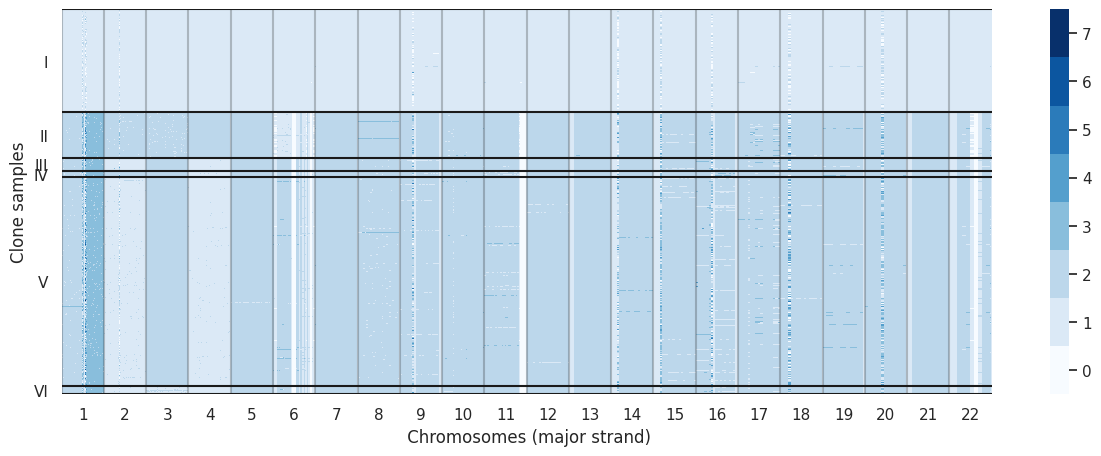

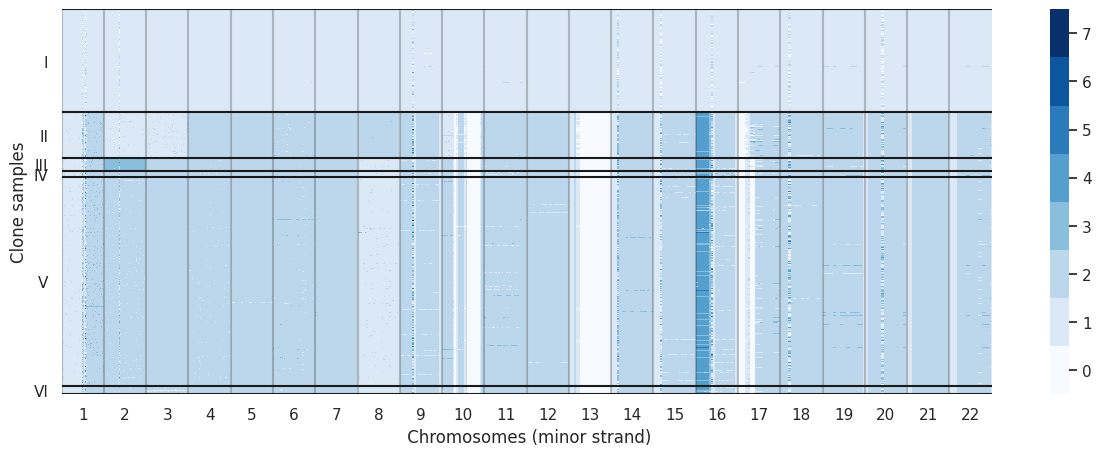

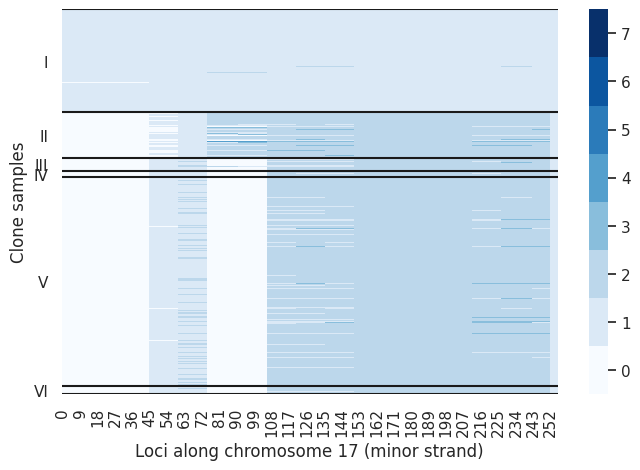

In [12]:
label_order = np.argsort(data[subset]["label"])
splits = np.insert(np.cumsum(counts[subset]), 0, 0)

print(data[subset]["CNA"].shape)

# All chromosomes
for _strand in range(1,3):
    features = data[subset]["CNA"][label_order, _strand-1, :, :]
    
    plot_chromosomes(features, 
                     splits=splits,
                     xlabel=f" Chromosomes ({'major' if _strand == 1 else 'minor'} strand)"
                    )
    plt.savefig(f"notebook/figs/{'Major' if _strand == 1 else 'Minor'}Strand.png", dpi=200, format='png', transparent=False)
    
    
# Single chromosome
plot_chromosome(data[subset]["CNA"][label_order, strand-1, chromosome-1, :],
                splits=splits,
                xlabel=f"Loci along chromosome {chromosome} ({'major' if strand == 1 else 'minor'} strand)")
plt.savefig(f"notebook/figs/{'Major' if _strand == 1 else 'Minor'}Strand_Chr{chromosome}.png", dpi=200, format='png', transparent=False)


## Plot the first k of each clone (for visual clarity due to class imbalance)

In the validation and test set there are few occurrences of the rare clusters, so we plot min(N,k) where N is the number of occurrences 

In [13]:
k = 10     # maximum number of samples to observe in each clone

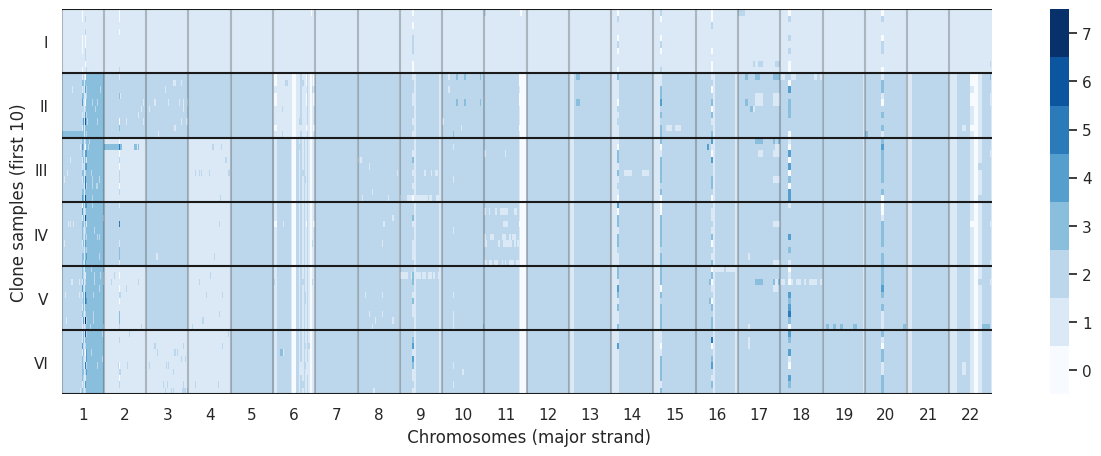

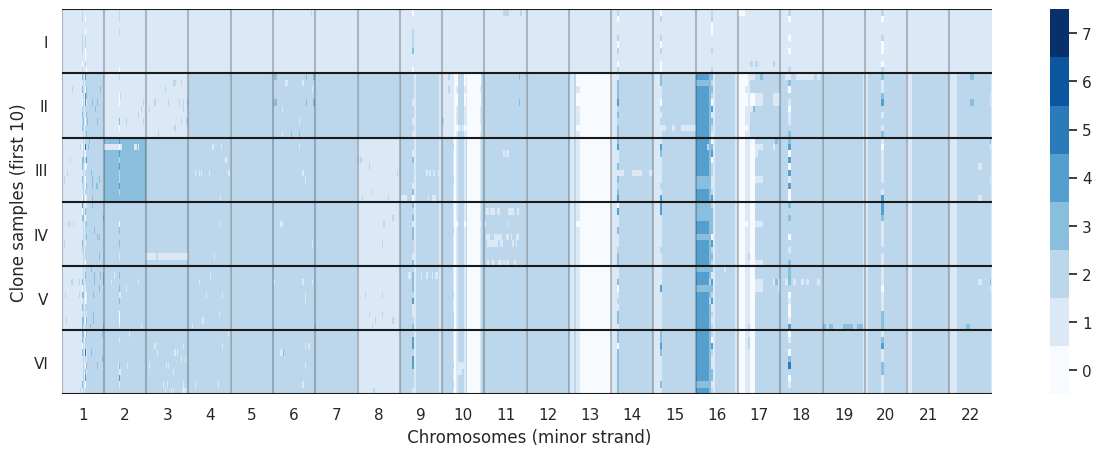

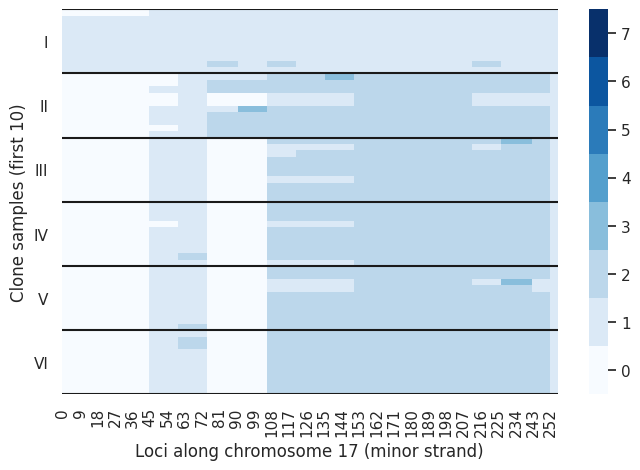

In [14]:
top_k = []
for clone in range(6):
    idx_top = np.where(data[subset]["label"] == clone)[0]
    _k = np.min((idx_top.shape[0], k))
    top_k.append(idx_top[:_k])
top_6k = np.concatenate(top_k, 0)
splits = np.insert(np.cumsum([len(_k) for _k in top_k]), 0, 0)

# All chromosomes
for _strand in range(1,3):
    features = data[subset]["CNA"][top_6k, _strand-1, :, :]
    plot_chromosomes(features, splits=splits, 
                     xlabel=f" Chromosomes ({'major' if _strand == 1 else 'minor'} strand)",
                     ylabel=f"Clone samples (first {k})")
    plt.savefig(f"notebook/figs/{'Major' if _strand == 1 else 'Minor'}Strand_top{k}.png", dpi=200, format='png', transparent=False)

# Single chromosome
plot_chromosome(data[subset]["CNA"][top_6k, strand-1, chromosome-1, :], 
                splits=splits, 
                xlabel=f"Loci along chromosome {chromosome} ({'major' if strand == 1 else 'minor'} strand)",
                ylabel=f"Clone samples (first {k})")
plt.savefig(f"notebook/figs/{'Major' if _strand == 1 else 'Minor'}Strand_Chr{chromosome}_top{k}.png", dpi=200, format='png', transparent=False)


# Model visualisations

Additional visualisation are provided at run-time with WandB logging callbacks.

Replace log file to view the same plots for other model types

In [15]:
# load from checkpoint
model = AttentiveAutoEncoder.load_from_checkpoint(f"outputs/checkpoints/{checkpoint}.ckpt")

# create a callback that will save meta outputs
test_data = stack_batches(dm.test_dataloader)
save_output = SaveOutput(test_samples=test_data,
                         file_path=f"notebook/{checkpoint}.pkl"
                         )

# and reproduce the reported results
trainer = pl.Trainer(callbacks=[save_output], logger=None)
trainer.test(model, dataloaders=dm.test_dataloader())

{'D': 3, 'wavelet': 'haar', 'J': 8, 'layers': 1, 'hidden_channels': 256, 'proj_size': 64}


/home/ubuntu/.pyenv/versions/waveLSTM/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.011819829232990742
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.011819829232990742}]

In [16]:
with open(f"notebook/{checkpoint}.pkl", 'rb') as file:
    meta_results = pkl.load(file)

# wave-LSTM outputs    
J = len(meta_results["resolution_embeddings"])
lbls = meta_results["labels"].cpu().numpy()
M = meta_results["M"]
Mbar = torch.mean(meta_results["M"], axis=1).cpu().numpy()
Mflat = torch.flatten(meta_results["M"], start_dim=1).cpu().numpy()
A = meta_results["attention"]

print(f"Available outputs: {[i for i in meta_results.keys()]}")

Available outputs: ['masked_inputs', 'masked_targets', 'resolution_embeddings', 'attention', 'M', 'masked_predictions', 'labels']


## Section 2.1: Visualise Wave-LSTM encoder output

## Visualisation of self-attention

We can also visualise the learnt self-attention, allowing us to see which resolutions the model thought were predictive.

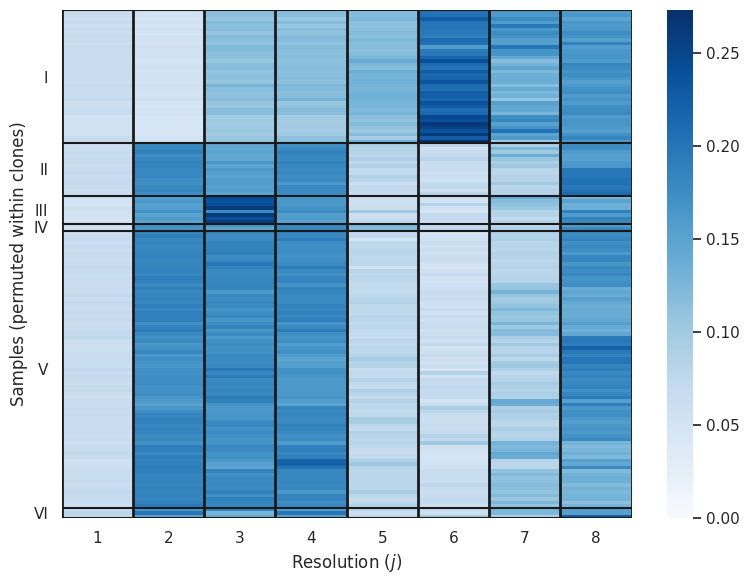

In [17]:
# Arguments
num_clusters = [4, 2, 3, 2, 10, 2]                    # The number of sub-clusters to split each clone into    

Abar = torch.mean(A, dim=1).cpu().numpy()

# Nested ordering (by biclustering attention)
atn_order = []
for idx_clone in range(6):
    lbl_idx = np.where(data[-1]["label"] == idx_clone)[0]
    atn_clone = Abar[lbl_idx, :]
    clustering = sklearn.cluster.AgglomerativeClustering(n_clusters=np.min((num_clusters[idx_clone], atn_clone.shape[0])))
    clustering.fit(atn_clone)
    permute_idx = np.argsort(clustering.labels_)
    atn_order.append(lbl_idx[permute_idx])
atn_order = np.concatenate(atn_order)

# Make permuted attention plot
fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.heatmap(Abar[atn_order, :], ax=ax, cmap='Blues', vmin=0, yticklabels=False)   # vmax=1
# Split clones
splits = np.insert(np.cumsum(counts[-1]), 0, 0)
for split in splits:
    plt.axhline(y=split, color='k', linestyle='-')
ax.set_yticks((splits[1:] + splits[:-1])/2)
ax.set_yticklabels(cluster_names)
ax.set_xticklabels([f"{j+1}" for j in range(J)], minor=False)    
# Split resolutions
for x_tick in [i for i in range(J)]:
    ax.vlines(x=x_tick, ymin=0, ymax=Abar.shape[0], linewidth=2, color='k')
ax.vlines(x=Abar.shape[1], ymin=0, ymax=Abar.shape[0], linewidth=2, color='k')
# 
ax.set_xlabel("Resolution $(j)$")
ax.set_ylabel("Samples (permuted within clones)")    # permuted
plt.ylim((splits[-1], 0, ))
plt.tight_layout()
plt.savefig(f"notebook/figs/{checkpoint}_attention.png", dpi=200, format='png', transparent=False)

## Visualise test features, permuted by attention

Plot test CNA features, permuted by the same order as attention above

Select which chromosome and strand to highlight, and whether we view the true test data or (the noise filtered) reconstruction. Viewing the less noisy reconstruction is recommended for any initial exploration.

In [18]:
chromosomes = [6, 22, 17]        # 1,...,22
strands = [1, 1, 2]              # major=1, or minor=2
assert len(chromosomes) == len(strands)
view_reconstruction = False

/tmp/ipykernel_15378/6292399.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


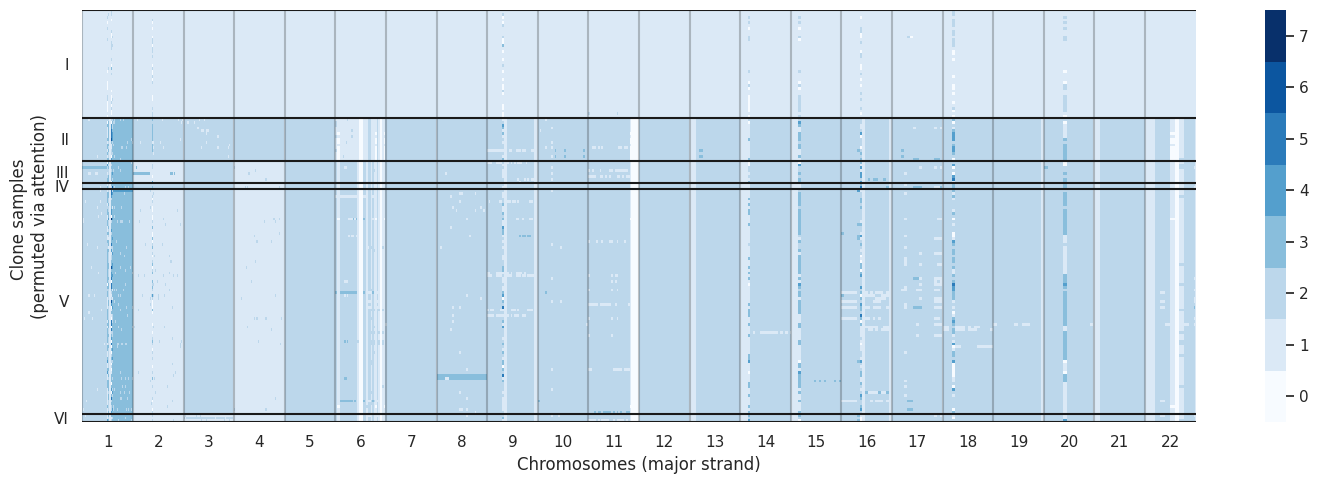

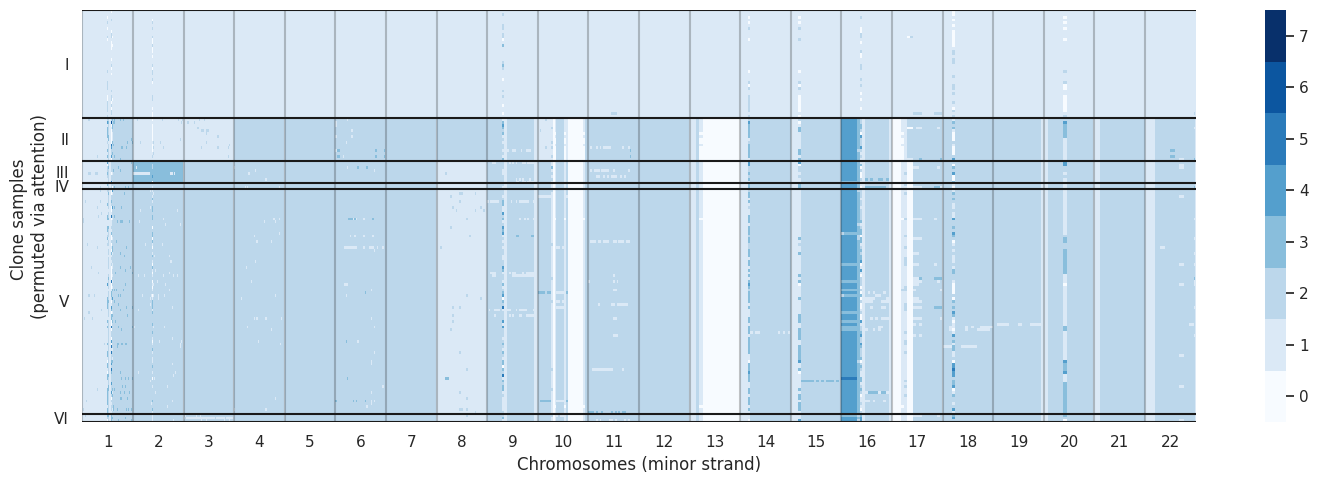

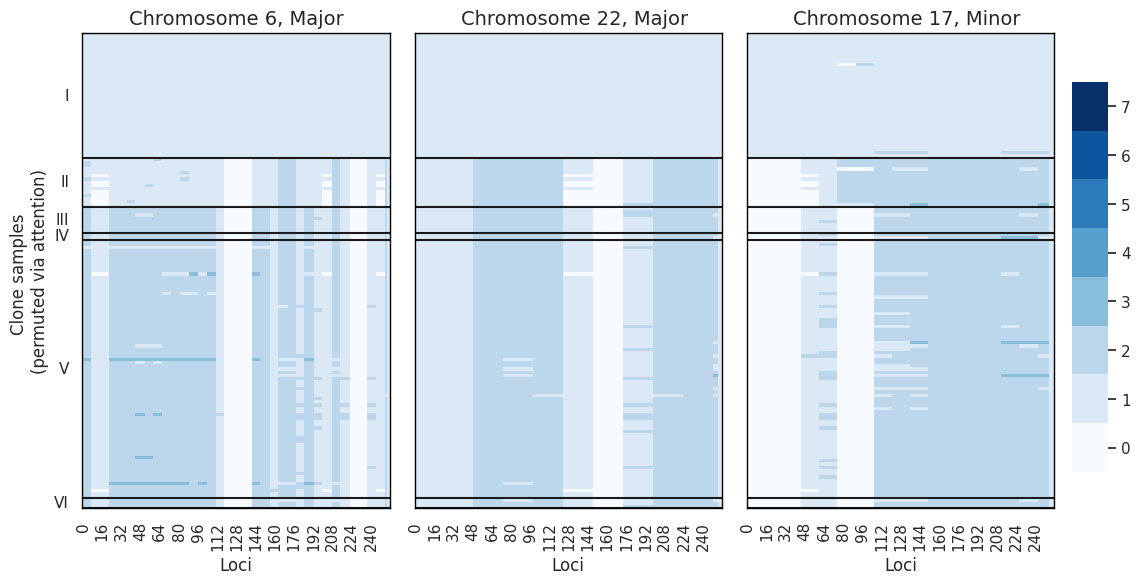

In [19]:
if view_reconstruction:
    test_features = meta_results["masked_predictions"][0].detach().cpu().numpy().reshape(-1,2,22,256)
    norm_mu, norm_std = np.mean(data[0]["CNA"], axis=0), np.std(data[0]["CNA"], axis=0)
    test_features *= norm_std
    test_features += norm_mu
else:
    test_features = data[-1]["CNA"]

splits = np.insert(np.cumsum(counts[-1]), 0, 0)    

# Stacked channels
for _strand in range(1,3):
    
    plot_chromosomes(test_features[atn_order, _strand-1, :, :],
                    splits=splits,
                    xlabel=f"Chromosomes ({'major' if _strand == 1 else 'minor'} strand)",
                    ylabel="Clone samples \n(permuted via attention)",
                    )
    plt.tight_layout()
    plt.savefig(f"notebook/figs/{checkpoint}_Strand{'Major' if _strand == 1 else 'Minor'}_PermuteAttention.png", dpi=200, format='png', transparent=False)
    
    
# Zoom in
fig, axes = plt.subplots(1, len(chromosomes), figsize=(12,6), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.9, .2, .03, .65])
for idx, ax in enumerate(axes):
    sns.heatmap(test_features[atn_order, strands[idx]-1, chromosomes[idx]-1, :], ax=ax, cmap=cmap, norm=norm, yticklabels=True, 
                cbar=idx == len(strands)-1, cbar_ax=cbar_ax if idx == len(strands)-1 else None)

    # Horizontal lines: separating sub-clusters
    for split in splits:
        ax.axhline(y=split, color='k', linestyle='-')
    
    # X-axis
    ax.set_xlabel(f"Loci")
    ax.set_xlim((0,256))
    # Manually specify colorbar labelling after it's been generated
    if idx == len(strands)-1:
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks(np.arange(0, 8))
        colorbar.minorticks_off() 

    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    ax.set_facecolor((0, 0, 0, 0))
    ax.text(.15, 1.05, f"Chromosome {chromosomes[idx]}, {'Major' if strands[idx]-1 == 0 else 'Minor'}", ha='left', va='top', transform=ax.transAxes, size=14)
 
# Y-axis
axes[0].set_yticks((splits[1:] + splits[:-1])/2)
axes[0].set_yticklabels(["I", "II", "III", "IV", "V", "VI"])
axes[0].set_ylabel(f"Clone samples \n(permuted via attention)", loc="center")

fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig(f"notebook/figs/{checkpoint}_Strand{'Major' if _strand == 1 else 'Minor'}_PermuteAttention_SubClonalsII.png", dpi=200, format='png', transparent=False)

## Visualise resolution-embeddings (vs. source-separated inputs)

We visualise the learnt $h_j$, and compare how this differs from source-separated input $X_j$. 

Create reducer. 

Note, there is a large imbalance in representation so the perplexity must be chosen to compromise between preserving local structures for under represented clones and the global structures of the larger clones.

In [20]:
# First, just create instance of whatever reducer we want to use throughout
reduce_method = "tSNE"         # tSNE or umap

if reduce_method.lower() == "umap":
    reducer = umap.UMAP(n_neighbors=15)
elif reduce_method.lower() == "tsne":
    reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=4)
else:
    raise NotImplementedError

# axis labels
proj1_label = f"{reduce_method}-1"
proj2_label = f"{reduce_method}-2"

In [21]:
data_res_emb = []
for j_res, j_name in zip([i for i in range(J)], [f"{j+1}" for j in range(J)]): 

    h_j = meta_results["resolution_embeddings"][j_res].cpu().numpy()
    x_j = meta_results["masked_inputs"][j_res].cpu().numpy()

    # Projection of scale embeddings, and source separated input
    for val, val_name in zip([h_j, x_j], ["h_j", "X_j"]):
        
        val = val.reshape((val.shape[0], -1))           # Reshape x_j to flatten channels
        val = StandardScaler().fit_transform(val)       # Scale before any transform
        
        embedding = reducer.fit_transform(val)
        for i in range(embedding.shape[0]):
            data_res_emb.append([i, 
                                 embedding[i, 0], embedding[i, 1], 
                                 val_name,
                                 j_name, cluster_names[data[-1]["label"][i]],
                                ])  

df_res_emb = pd.DataFrame(data_res_emb, columns=["sample", proj1_label, proj2_label, "source", "resolution", "Clone"])
display(df_res_emb)

,sample,tSNE-1,tSNE-2,source,resolution,Clone
0,0,-9.322074,-6.302569,h_j,1,V
1,1,15.750802,40.569374,h_j,1,I
2,2,-11.822342,-43.580734,h_j,1,III
3,3,-2.443575,-28.234209,h_j,1,V
4,4,-52.288929,1.365715,h_j,1,V
...,...,...,...,...,...,...
2315,140,-2.668401,53.868420,X_j,8,I
2316,141,-2.881413,-31.595591,X_j,8,V
2317,142,-7.823931,50.518776,X_j,8,I
2318,143,14.486198,-19.910688,X_j,8,V


Choose which subset to view

In [22]:
resolutions = [1,3,5,8]                           # 1,..., J
# resolutions = [1,2,3,4]                           # 1,..., J

sources = ["X_j", "h_j"]                          # Source separated input and/or resolution embeddings
clones = ["I", "II", "III", "IV", "V", "VI"]      # Choose to zoom into clones

/home/ubuntu/.pyenv/versions/waveLSTM/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_15378/1540784354.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


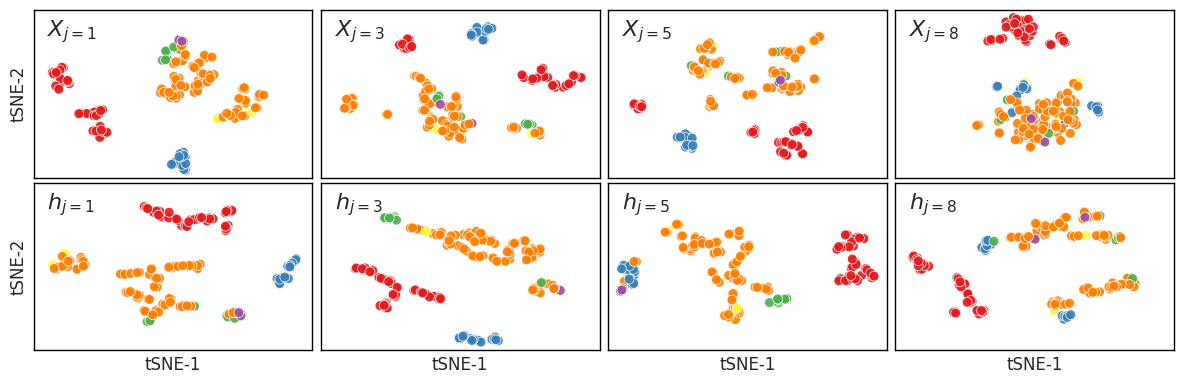

In [23]:
# Plot 
df_fig2 = df_res_emb[df_res_emb["resolution"].isin([f"{i}" for i in resolutions])]
df_fig2 = df_fig2[df_fig2["source"].isin(sources)]
df_fig2 = df_fig2[df_fig2["Clone"].isin(clones)]           # Zoom into subset of classes
# display(df_fig2)

g = sns.relplot(data=df_fig2, x=proj1_label, y=proj2_label,  row="source", col="resolution", hue="Clone", hue_order=clones,
                row_order=sources,
                legend=False, s=50, alpha=0.9,
                height=2, aspect=1.5,
                palette="Set1",
                facet_kws={'sharey': True, 'sharex': True, 'margin_titles': True, 'despine': False,}
               )
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="", col_template="")
    

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label=f"{reduce_method}-1", clear_inner=True)
g.set_ylabels(label=f"{reduce_method}-2", clear_inner=True)

spaces = []
tmp1 = r"_{j="
tmp2 = r"}"
[[ spaces.append(f"${i[0]}{tmp1}{j}{tmp2}$") for j in resolutions] for i in sources] 
for ax, space in zip(g.axes.flatten(), spaces ):  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    ax.set_facecolor((0, 0, 0, 0))
    ax.text(.05, .95, f'{space}', ha='left', va='top', transform=ax.transAxes, size=16)

# Adjust margins
plt.tight_layout()
g.figure.subplots_adjust(wspace=0.03, hspace=0.03)
        
plt.savefig(f"notebook/figs/{checkpoint}_ResolutionEmbeddings.png", dpi=200, format='png', transparent=False)

We find that $h_j$ benefits from the information flow through the LSTM model. Embeddings are improved by

* the additional label/task information, leading to adaptive filtering.
* the ability of the LSTM model to pass information through the recurrent cell states. E.g. Whilst the orange class was separable at $X_{j=4}$, and subsequently not - within the resolution embeddings that information has been retained for $h_{j\geq4}$. Note, this behaviour can be controlled through reducing and increasing the capacity of the hidden states.

We can view all of the resolution embeddings

/home/ubuntu/.pyenv/versions/waveLSTM/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_15378/1303824792.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


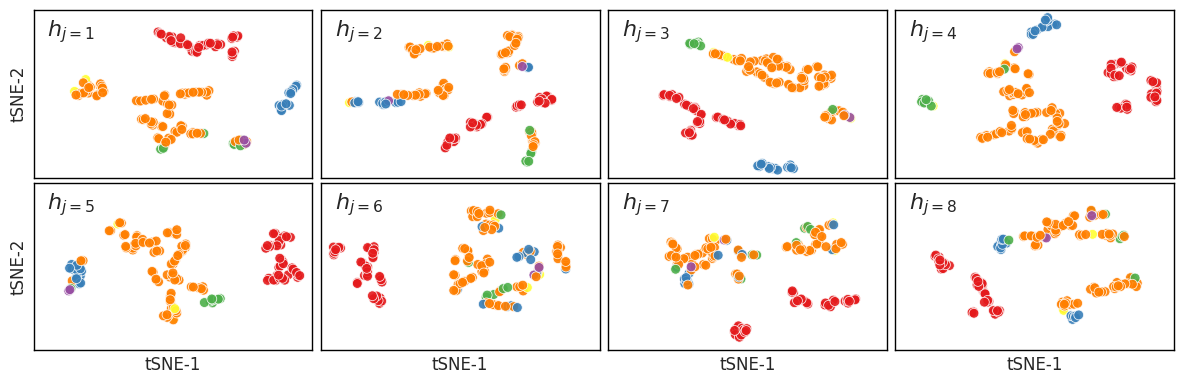

In [24]:
# Wrapped version of the above, for _either_ source separated input or resolution embedding
resolutions = [_ for _ in range(1,9)] 
sources = ["h_j"]  # "X_j",
clones = ["I", "II", "III", "IV", "V", "VI"]

# Plot 
df_fig2 = df_res_emb[df_res_emb["resolution"].isin([f"{i}" for i in resolutions])]
df_fig2 = df_fig2[df_fig2["source"].isin(sources)]
df_fig2 = df_fig2[df_fig2["Clone"].isin(clones)]
# display(df_fig2)

g = sns.relplot(data=df_fig2, x=proj1_label, y=proj2_label,  col="resolution", hue="Clone", hue_order=clones,
                col_wrap=4,
                legend=False, s=50, alpha=0.9,
                height=2, aspect=1.5,
                palette="Set1",
                facet_kws={'sharey': True, 'sharex': True, 'margin_titles': True, 'despine': False,}
               )
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="", col_template="")
    

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label=f"{reduce_method}-1", clear_inner=True)
g.set_ylabels(label=f"{reduce_method}-2", clear_inner=True)

spaces = []
tmp1 = r"_{j="
tmp2 = r"}"
[[ spaces.append(f"${i[0]}{tmp1}{j}{tmp2}$") for j in resolutions] for i in sources] 
for ax, space in zip(g.axes.flatten(), spaces ):  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    ax.set_facecolor((0, 0, 0, 0))
    ax.text(.05, .95, f'{space}', ha='left', va='top', transform=ax.transAxes, size=16)

# Adjust margins
plt.tight_layout()
g.figure.subplots_adjust(wspace=0.03, hspace=0.03)
# plt.gcf().set_size_inches(8, 3.5)
        
plt.savefig(f"notebook/figs/{checkpoint}_ResolutionEmbeddings_{sources[0]}.png", dpi=200, format='png', transparent=False)

## Visualisation of the multi-resolution embedding

We can visualise the embedding tensor $M$ by either flattening, or taking the average across hops. For this example $r_{\text{hops}}=1$, and so they are equivalent.

In [25]:
Mbar = torch.mean(M, axis=1).cpu().numpy().reshape((M.shape[0], -1))

# Construct dataframe
data_mres_emb = []
embedding = reducer.fit_transform(Mbar)
for i in range(embedding.shape[0]):
    data_mres_emb.append([i,
                          embedding[i, 0], embedding[i, 1], 
                          "Mbar",
                          cluster_names[data[-1]["label"][i]]
                         ])  
df_mres_emb = pd.DataFrame(data_mres_emb, columns=["sample", proj1_label, proj2_label, "source", "Clone"])
# display(df_mres_emb)

/home/ubuntu/.pyenv/versions/waveLSTM/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_15378/1909700639.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


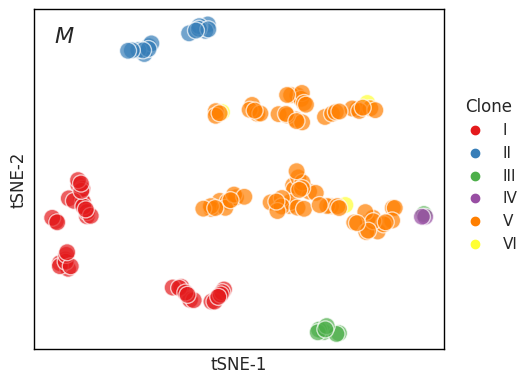

In [26]:
# df_mres_emb = df_mres_emb[df_mres_emb["Clone"].isin(["Clone I"])]           # Zoom into subset of classes

g = sns.relplot(data=df_mres_emb, x=proj1_label, y=proj2_label,  col="source", hue="Clone", hue_order=clones,
                row_order=sources,
                legend=True, s=150, alpha=0.7,
                height=4, aspect=1,
                palette="Set1",
                facet_kws={'sharey': True, 'sharex': True, 'margin_titles': True, 'despine': False,}
               )
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="", col_template="")

leg = g._legend
leg.set_bbox_to_anchor([0.95, 0.75])
leg._loc = 2 

g.set_titles(col_template="", row_template="")    # {row_name}

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label=proj1_label, clear_inner=True)
g.set_ylabels(label=proj2_label, clear_inner=True)

for ax in g.axes.flatten():  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    ax.set_facecolor((0, 0, 0, 0))
    ax.text(.05, .95, r'$M$', ha='left', va='top', transform=ax.transAxes, size=16)

# Adjust margins
plt.tight_layout()
        
plt.savefig(f"notebook/figs/{checkpoint}_MultiResolutionEmbedding.png", dpi=200, format='png', bbox_inches='tight', transparent=False)

## How clusters in resolution space look in feature space

i.e. what features are certain resolutions making distinctions upon.

/tmp/ipykernel_15378/256013907.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


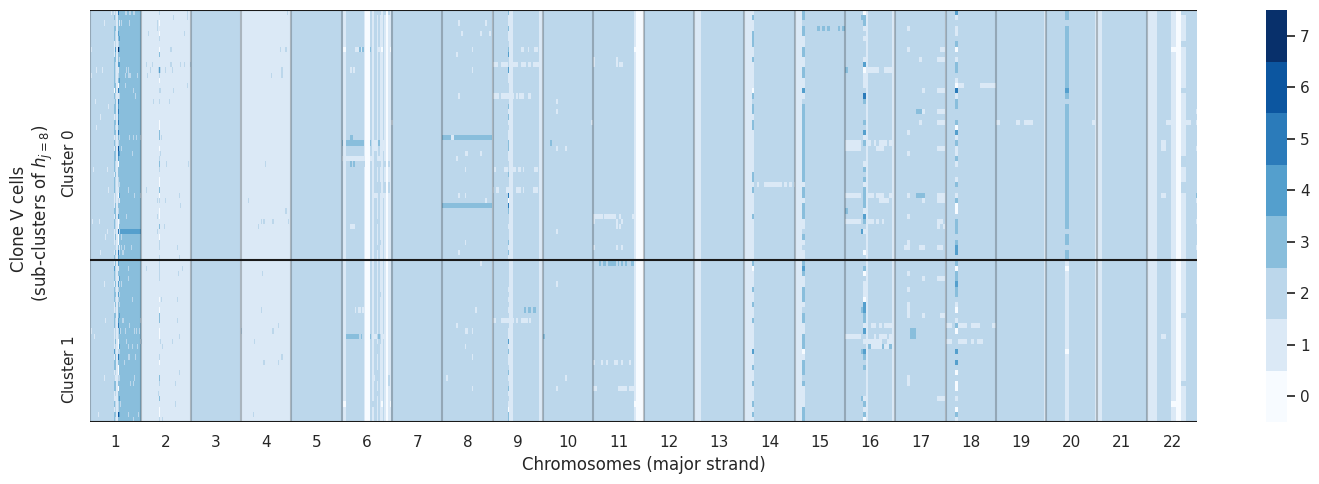

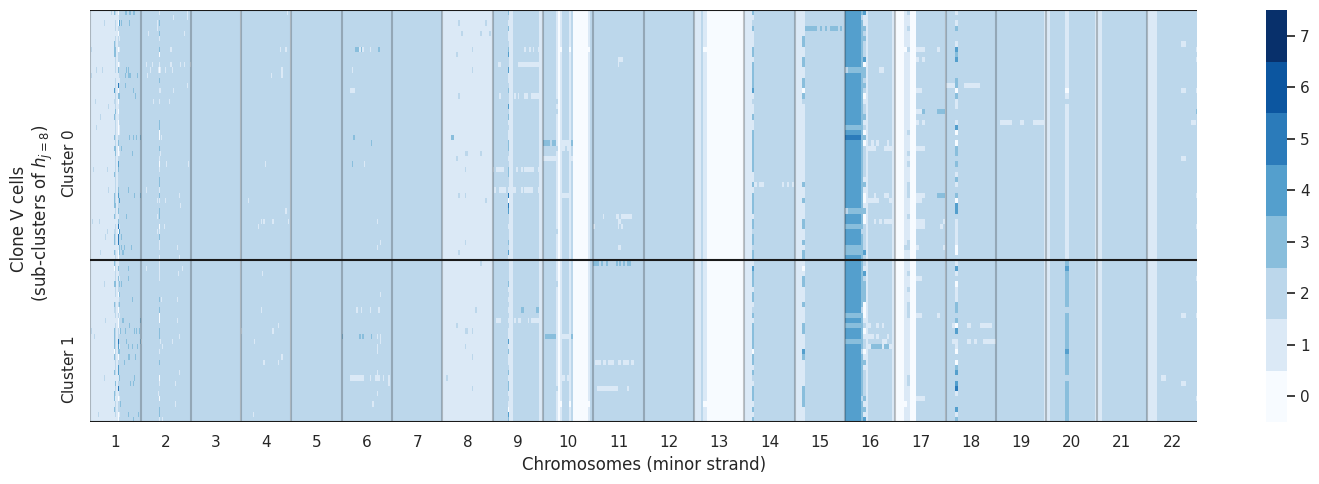

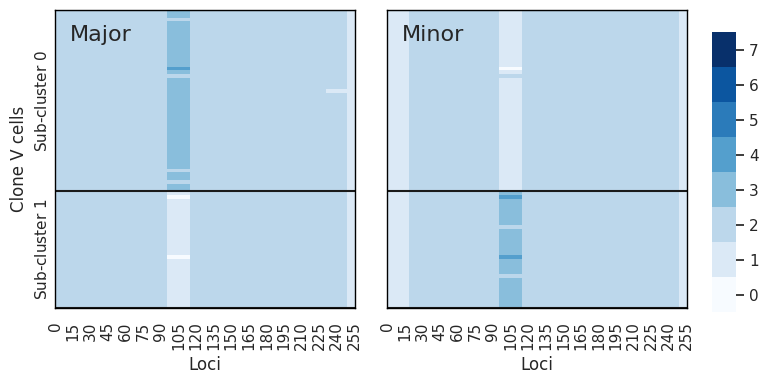

In [27]:
# Which latent space we wish to visualise
j = 8
clone = "V"
num_clusters = 2

# Which strand and chromosome to zoom into
chromosomes = [20]    # [_ for _ in range(23)]

df_res_emb_cluster = df_res_emb[(df_res_emb["source"]=="h_j") & 
                                (df_res_emb["Clone"]==clone) & 
                                (df_res_emb["resolution"] == str(j))
                                 ]
features = data[-1]["CNA"][df_res_emb_cluster["sample"], :, :, :]
# display(df_res_emb_cluster)

clustering = sklearn.cluster.AgglomerativeClustering(n_clusters=num_clusters)
clustering.fit(df_res_emb_cluster[[proj1_label, proj2_label]])
permute_idx = np.argsort(clustering.labels_)
sub_counts = [len(np.where(clustering.labels_==i)[0]) for i in range(num_clusters)]

# Stacked channels
for _strand in range(1,3):
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    sns.heatmap(features[permute_idx, _strand-1, :, :].reshape((-1, 22*256)), 
                ax=ax, cmap=cmap, norm=norm, yticklabels=False,
               ) 
    # Vertical lines: indicating which chromosome we are zooming into in third plot
    for _chrom in range(1, 23):
        plt.axvline(x=(_chrom-1)*256, color='k', alpha=0.25)
    # Horizontal lines: separating sub-clusters
    splits = np.insert(np.cumsum(sub_counts), 0, 0)
    for split in splits:
        plt.axhline(y=split, color='k', linestyle='-')
    # Label y-axis
    ax.set_yticks((splits[1:] + splits[:-1])/2)
    ax.set_yticklabels([f"Cluster ${_i}$" for _i in range(num_clusters)], rotation=90)
    plt.ylim((len(permute_idx), 0, ))
    plt.ylabel(f"Clone {clone} cells \n (sub-clusters of $h{tmp1}{j}{tmp2}$)")
    # X-axis
    ax.set_xticks([ (_chrom+0.5) * 256 for _chrom in range(22)])
    ax.set_xticklabels([_chrom for _chrom in range(1,23)], rotation=0)
    plt.xlabel(f"Chromosomes ({'major' if _strand == 1 else 'minor'} strand)")
    # Manually specify colorbar labelling after it's been generated
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks(np.arange(0, 8))
    colorbar.set_ticklabels([i for i in range(8)])
    colorbar.minorticks_off() 
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"notebook/figs/{checkpoint}_Clone{clone}_{num_clusters}Subclusters_hj{j}_strand{_strand}.png", dpi=200, format='png', transparent=False)   
            
for chromosome in chromosomes:        
    # Zoom in
    fig, axes = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.9, .2, .03, .7])
    splits = np.insert(np.cumsum(sub_counts), 0, 0)
    for strand, ax in enumerate(axes):
        sns.heatmap(features[permute_idx, strand, chromosome-1, :], ax=ax, cmap=cmap, norm=norm, yticklabels=True, 
                    cbar=strand == 0, cbar_ax=None if strand else cbar_ax)
        # Horizontal lines: separating sub-clusters
        for split in splits:
            ax.axhline(y=split, color='k', linestyle='-')
        # X-axis
        ax.set_xlabel(f"Loci")
        ax.set_xlim((0,256))
        # Manually specify colorbar labelling after it's been generated
        if not strand:
            colorbar = ax.collections[0].colorbar
            colorbar.set_ticks(np.arange(0, 8))
            colorbar.minorticks_off() 
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        ax.set_facecolor((0, 0, 0, 0))
        ax.text(.05, .95, f"{'Major' if strand == 0 else 'Minor'}", ha='left', va='top', transform=ax.transAxes, size=16)
    
    # # Y-axis
    axes[0].set_yticks((splits[1:] + splits[:-1])/2)
    axes[0].set_yticklabels([f"Sub-cluster ${_i}$" for _i in range(num_clusters)], rotation=90, fontdict={'horizontalalignment': "center"})   # \n (sub-clusters of $h{tmp1}{j}{tmp2}$)
    axes[0].set_ylabel(f"Clone {clone} cells", loc="center")
    fig.tight_layout(rect=[0, 0, .9, 1])
    plt.savefig(f"notebook/figs/{checkpoint}_Clone{clone}_{num_clusters}Subclusters_hj{j}_Chr{chromosome}.png", dpi=200, format='png', transparent=False)   